In [3]:
"""Test module for explanation ai implemented with LIME"""
import os
import json
import numpy as np
import pandas as pd

from temporalnn.explain.lime import LIMETimeSeries
from keras.models import load_model

DATA_DIR = "notebooks/data" if os.path.isdir("notebooks") else "data"


Using TensorFlow backend.


In [4]:
def preload_uts(data_dir=DATA_DIR):
    df = pd.read_csv(f"{data_dir}/climate_small.csv")
    with open(f"{data_dir}/climate_small_schema.json") as f:
        schema = json.load(f)
        df = df.astype(schema)

    df = df.set_index("measure_date")
    tmk = df.query("stations_id == 2074")["tmk"]

    input_steps = 32
    return tmk[-input_steps:].to_numpy()

In [5]:
model = load_model(f"{DATA_DIR}/uts_tmk_32_1.h5")
def predict_uts_tmk(x, *args):
    _shape = x.shape
    if len(_shape) == 2:
        _shape = (1, _shape[0], _shape[1])
    elif len(_shape) == 1:
        _shape = (1, _shape[0], 1)
    x = x.reshape(_shape)

    y_hat = model.predict(x, *args)

    # flatten to one value
    return y_hat.ravel().item()

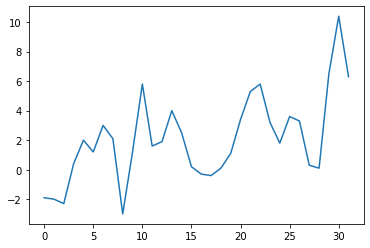

In [6]:
import matplotlib.pyplot as plt

ts_original = preload_uts()
plt.plot(ts_original)

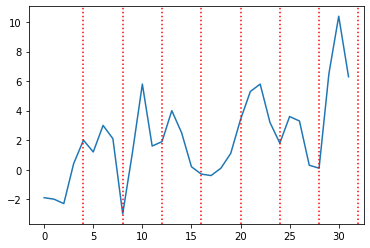

In [15]:
xai_uts = LIMETimeSeries(x=ts_original)
ts_segmented, ts_features = xai_uts.to_features()
xai_uts.x_segmented = ts_segmented
xai_uts.x_features = ts_features

plt.plot(ts_original)
for i in range(len(ts_segmented)):
    n_features = len(ts_segmented[i])
    p_x = n_features * (i + 1)
    plt.axvline(x=p_x, c='r', ls=':')

    text_x = p_x - (n_features / 2) # center
    text_y = min(ts_original) - 3   # manually
    # plt.text(text_x, text_y, r"$w_{%i}$" % i, c='r')


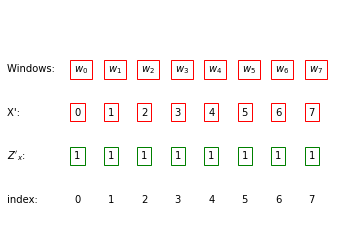

In [8]:
arr = ts_features
row_relative = [0.7, 0.5, 0.3, 0.1]

plt.axis('off')
plt.text(0, row_relative[0], r"Windows: ")
plt.text(0, row_relative[1], r"X': ")
plt.text(0, row_relative[2], r"${Z'}_x$: ")
plt.text(0, row_relative[3], 'index:')
for i, c in enumerate(arr):
    p_x = (i + 2) * 0.1
    plt.text(p_x, row_relative[0], r"$w_{%i}$" % i, bbox=dict(facecolor='none', edgecolor='red'))
    plt.text(p_x, row_relative[1], c, bbox=dict(facecolor='none', edgecolor='red'))
    plt.text(p_x, row_relative[2], 1, bbox=dict(facecolor='none', edgecolor='green'))
    plt.text(p_x, row_relative[3], i, )

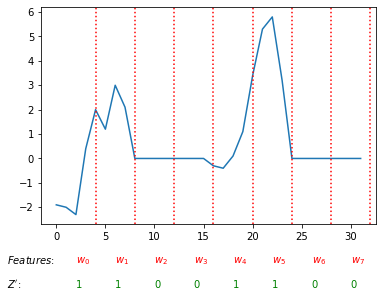

In [19]:
# Todo: plot (z_original + z' + axvline)
z_comma = np.random.choice(a=[1, 0], size=len(ts_features))
z_original = xai_uts.to_original_form(z_comma)

plt.plot(z_original)
w_text_y = min(z_original) - 2   
z_text_y = w_text_y - 1
plt.text(-5, w_text_y, r"$Features$: ")
plt.text(-5, z_text_y, r"$Z'$: ")
for i in range(len(ts_segmented)):
    n_features = len(ts_segmented[i])
    p_x = n_features * (i + 1)
    plt.axvline(x=p_x, c='r', ls=':')

    text_x = p_x - (n_features / 2) # center
    plt.text(text_x, w_text_y, r"$w_{%i}$" % i, c='r')
    plt.text(text_x, z_text_y, z_comma[i], c='g')

In [10]:
xai_uts = LIMETimeSeries(x=ts_original, predict_fn=predict_uts_tmk)
xai_model = xai_uts.explain(on_offs=[1, 0])
xai_model.coef_

array([ 0.19979857,  0.34279619,  0.05906634, -0.49667998, -0.51279553,
        0.75224822,  0.18612745,  3.01063521])

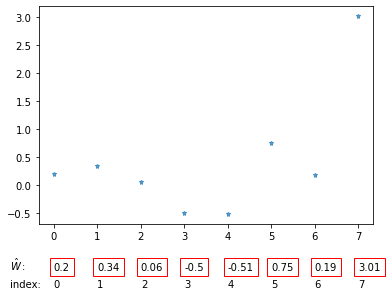

In [14]:
arr = xai_model.coef_.round(2)

w_text_y = min(arr) - 1 
z_text_y = w_text_y - 0.3
plt.plot(xai_model.coef_, alpha=0.7, linestyle='none', marker='*', markersize=5)

plt.text(-1, w_text_y, r"$\hatW:$ ")
plt.text(-1, z_text_y, 'index:')
for i, c in enumerate(arr):
    plt.text(i, w_text_y, c, bbox=dict(facecolor='none', edgecolor='red'))
    plt.text(i, z_text_y, i, )

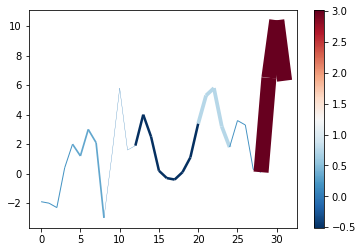

In [12]:
# Plot ts_original with highlighting important points
from matplotlib.collections import LineCollection
import matplotlib.colors as colors

# Weight features -> to weight for each point
weight_features = xai_model.coef_.round(2)
weight_points = np.ones_like(ts_original)
for i, w in enumerate(weight_features):
    start = i * n_features
    weight_points[start : start + n_features] = w

# Create coordinates (x, y)
# Line-starts from : 0 -> semi-last (-1)
# Line-ends from : 1 -> final
coords = list(enumerate(ts_original))
line_widths = 5 * abs(weight_points)
# line_widths = (1 + weight_points) ** 2
color_map = plt.cm.get_cmap('RdBu_r')
color_norm = colors.Normalize()

lines = [(start, end) for start, end in zip(coords[:-1], coords[1:])]
lines = LineCollection(lines, linewidths=line_widths, array=weight_points, norm=color_norm, cmap=color_map)
# Alternative with lines.set_array(.), lines.set_widths()

fig, ax = plt.subplots()
line = ax.add_collection(lines)
ax.autoscale()
plt.colorbar(line)